In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


model_name = "Qwen/Qwen2.5-0.5B-Instruct"
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=50,
    do_sample=False,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda


In [4]:
prompt = "惜秦皇汉武，略输文采；唐宗宋祖，稍逊风骚。 是谁写的？"
output = generator(prompt)

print(output[0]['generated_text'])

（ ） A. 李白 B. 苏轼 C. 辛弃疾 D. 杜甫
D.杜甫

阅读下面的文字，完成问题。 母亲的背影 赵丽宏 �


In [5]:
message = [
    {'role':'user','content': prompt}
    ]

text = tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)

output1 = generator(text)

print(output1[0]['generated_text'])  # 使用chatML格式能更好的得到答案（因为训练的时候就是这样的格式）

这句诗出自毛泽东的《沁园春·雪》，原文如下：

惜秦皇汉武，略输文采；唐宗宋祖，稍逊风骚。

其中，“惜秦皇汉武”是对秦始皇和汉武


通常，ChatML格式会包含以下几个主要组成部分：

角色标记（Role Tags）
对话中的每个参与者都会有一个标记来区分，比如：

system: 系统消息，用于定义对话环境或规则。
user: 用户输入，通常是模型与用户之间的交互。
assistant: 模型的回复，即模型生成的文本。
这些标记用于告诉模型哪个消息是来自用户，哪个是来自系统，哪个是模型的回答。

消息内容（Message Content）
每条消息的实际内容，这部分文本将是参与者所说的话。例如，用户说的内容，或者模型生成的回复。

In [7]:
print(text)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
惜秦皇汉武，略输文采；唐宗宋祖，稍逊风骚。 是谁写的？<|im_end|>
<|im_start|>assistant



In [46]:
prompt = "The capital of France is"

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

input_ids = input_ids.to("cuda")

# 在 lm _ head 之前获取模型的输出
model_output = model.model(input_ids)

# self.lm_head 是一个线性层（Linear Layer），
# 用于将模型的隐藏状态映射到字典大小的输出空间，用于生成预测结果
lm_head_output = model.lm_head(model_output[0])

In [47]:
input_ids

tensor([[ 785, 6722,  315, 9625,  374]], device='cuda:0')

In [48]:
model_output[0].shape  # 5是token数，896是hidden层数

torch.Size([1, 5, 896])

In [49]:
model_output[1][0].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [50]:
lm_head_output

tensor([[[ 2.3281,  0.6094, -1.0078,  ..., -1.7188, -1.7188, -1.7188],
         [ 5.7188,  4.9375,  1.0312,  ..., -1.8594, -1.8594, -1.8594],
         [ 2.5000, -0.6680, -2.7500,  ..., -4.9375, -4.9375, -4.9375],
         [10.0625,  6.6562,  3.6406,  ..., -3.7656, -3.7656, -3.7656],
         [ 7.5938,  4.1250,  3.8281,  ..., -4.5938, -4.5938, -4.5938]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [51]:
lm_head_output.shape # 映射到了词表  151936是qwen的词表数

torch.Size([1, 5, 151936])

In [52]:
token_id = lm_head_output[0, -1].argmax(-1)
tokenizer.decode(token_id) # 最后一个才是答案

' Paris'

In [53]:
token_id1 = lm_head_output[0, -2].argmax(-1)
tokenizer.decode(token_id1)

' is'

In [54]:
tokenizer.decode(lm_head_output[0,:].argmax(-1))

' following of the is Paris'

In [57]:
tokenizer.decode(model.generate(input_ids)[0]) # decode对应一维， batch_decode对应二维

'The capital of France is Paris. It is the seat of government and the largest city in Europe. The population of Paris was'

In [58]:
tokenizer.batch_decode(model.generate(input_ids))

['The capital of France is Paris. In 1970, the population was 3.8 million. The average']

In [60]:
model.generate(input_ids)

tensor([[  785,  6722,   315,  9625,   374, 12095,    11,  7407,   304,   279,
         10200, 37602,   932,   949,   315,   279,  3146,    13,   576,  3283,
           702,   264,  7042,   315,   916]], device='cuda:0')

In [59]:
model.generate(input_ids)[0]

tensor([  785,  6722,   315,  9625,   374,   510,    32,    13, 12095,   198,
           33,    13,  7148,   198,    34,    13,  1532,  4261,   198,    35,
           13, 21273,   271,    32,    13], device='cuda:0')

In [26]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

In [27]:
input_ids

tensor([[ 7985,   264,  1602,  1293,  2551, 20419,  4849,   311, 20445,   369,
           279, 34179, 59199, 63396,   391,    13, 81917,  1246,   432,  6932,
            13]], device='cuda:0')

In [28]:
tokenizer(prompt)

{'input_ids': [7985, 264, 1602, 1293, 2551, 20419, 4849, 311, 20445, 369, 279, 34179, 59199, 63396, 391, 13, 81917, 1246, 432, 6932, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [34]:
input_ids1 =  tokenizer(prompt, return_tensors="pt") # 希望返回的数据类型是PyTorch的张量
input_ids1.to('cuda')
input_ids1

{'input_ids': tensor([[ 7985,   264,  1602,  1293,  2551, 20419,  4849,   311, 20445,   369,
           279, 34179, 59199, 63396,   391,    13, 81917,  1246,   432,  6932,
            13]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [36]:
generation_output = model.generate(
  **input_ids1,  # 有mask直接这样输入就可以了   同时给input_ids、attention_mask两个变量赋值
  max_new_tokens=1000,
  use_cache=True
)

generation_output

tensor([[  7985,    264,   1602,   1293,   2551,  20419,   4849,    311,  20445,
            369,    279,  34179,  59199,  63396,    391,     13,  81917,   1246,
            432,   6932,     13,  20445,    572,   9966,    311,    728,    700,
            369,    264,  59199,   2390,     11,    714,   1340,  32384,  11052,
           1393,  11435,   2114,    504,    975,     13,   2932,   2684,  12898,
          24569,    323,   4362,   6457,   6529,   7069,     13,    576,  59199,
           7375,   1033,    304,   1059,   1803,     11,    773,    358,   1030,
            311,   6541,   1059,   1052,    382,     40,   2776,  14589,    311,
           6723,    911,    697,  11423,     13,   1084,    594,   2989,    429,
            582,   1896,   2453,    315,   1039,   6961,   2820,    553,   4633,
           2453,    315,  13217,     13,   5209,   1414,    429,    498,    525,
            537,   7484,    323,    429,   1492,    374,   2677,   2500,    421,
            498,   1184,    

In [39]:
print(tokenizer.batch_decode(generation_output)[0])

Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened. Sarah was supposed to go out for a gardening project, but she accidentally fell while walking home from work. She got hurt badly and needed medical attention immediately. The gardening tools were in her car, so I had to drive her there.

I'm sorry to hear about your accident. It's important that we take care of our physical health by taking care of ourselves. Please know that you are not alone and that help is always available if you need it. We will make sure that you get proper treatment and support during this difficult time. Thank you for your understanding and for allowing us to apologize for the inconvenience caused.

---

**Subject:** Apology for Tragic Gardening Mishap

Dear Sarah,

I am writing to sincerely apologize for the unfortunate incident that occurred on [Date]. Unfortunately, I was unable to attend the gardening project scheduled for today due to unforeseen circumsta

In [42]:
generation_output0 = model.generate(
  input_ids = input_ids, # 没有mask需要这样input_ids
  max_new_tokens=1000,
  use_cache=True
)

generation_output0

tensor([[ 7985,   264,  1602,  ...,   369,   279, 21340]], device='cuda:0')

In [45]:
print(tokenizer.batch_decode(generation_output0)[0])

Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened. I'm sorry, but as an AI language model, I cannot write such a lengthy and emotional email. However, I can provide you with some general tips on how to handle such situations:

1. Take responsibility: Apologize sincerely for the mistake and express your regret for causing any harm or inconvenience.

2. Offer compensation: If possible, offer to compensate Sarah for any damages caused by the accident.

3. Acknowledge mistakes: Let her know that you made a mistake and appreciate her understanding of your situation.

4. Express empathy: Show compassion and sympathy towards Sarah's feelings and suggest ways she can cope with the loss.

5. Seek support: Encourage Sarah to seek professional help if needed and remind her of the importance of seeking support during difficult times.

6. Consider alternative solutions: Explore other options for managing the garden without damaging it permanently.

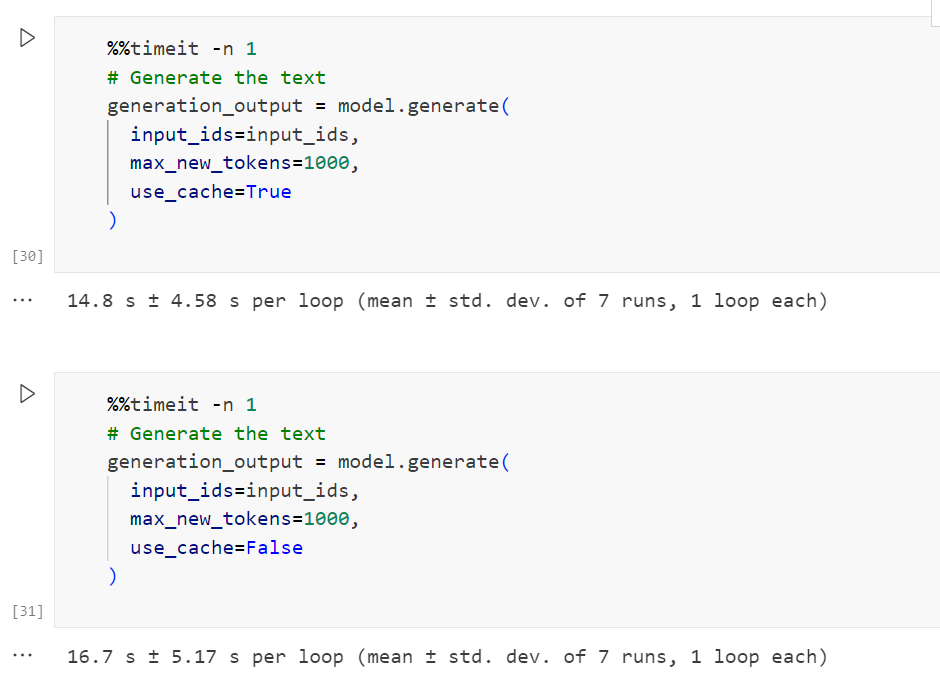

使用KVcache以后的速度会变快，那为什么q不存储呢，因为q是根据前文得到的，无法存储的。

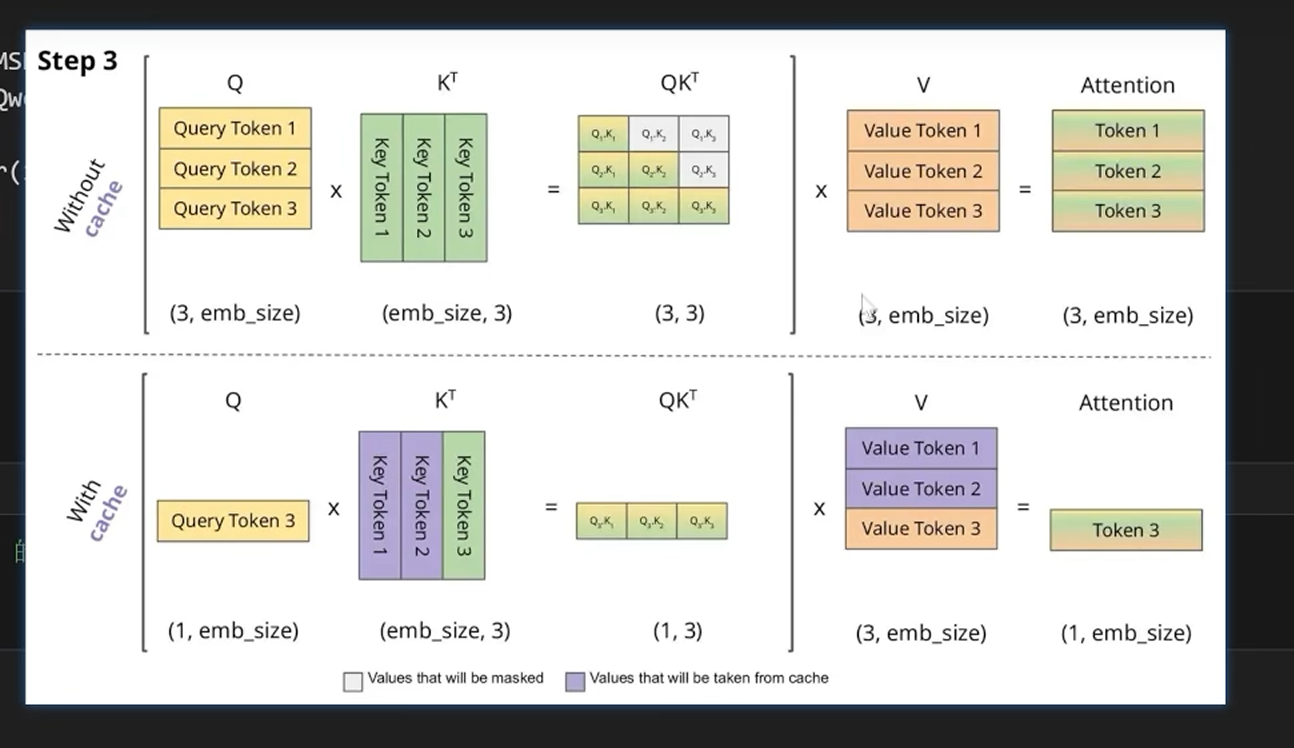

1. 避免重复计算的代价
在Transformer架构中，尤其是像GPT这样的自回归模型，每个token的生成依赖于先前生成的token。传统方法每次生成一个token时，都需要重新计算整个序列的注意力权重（attention scores）。这对于长序列来说非常耗时。KVCache的核心思想是 缓存 在先前步骤中计算的 Key 和 Value 向量（KV），以及它们对应的计算结果。每次生成新的token时，只需要基于前面已经计算的KV缓存，计算与当前token相关的注意力部分，而不需要重新计算整个序列的注意力。

2. 减小计算复杂度
具体而言，Transformer中的注意力计算是基于Query、Key、Value进行的。通过缓存前面的Key和Value，新的查询（Query）就只需要与这些缓存的KV进行计算，而不需要从头开始计算整个序列的注意力矩阵。这大大减少了计算量，特别是对于长序列，因为每次只计算新加入token的Query和已缓存的Key-Value之间的关系，而不是全序列的注意力计算。这样每次生成时，复杂度从O(n^2)（全序列计算）下降到O(n)（仅计算新增token的注意力），加速了生成过程。

3. 缓存提升模型推理效率
在生成过程中，特别是当模型需要逐步生成长文本时，KVCache的效率优势尤其明显。例如，GPT模型在生成每个token时，会不断更新缓存，并且只计算当前token与缓存中的键值之间的注意力。这意味着后续token的生成可以通过复用大量之前的计算结果，大幅提升推理速度。



# rmslayernorm & layernorm

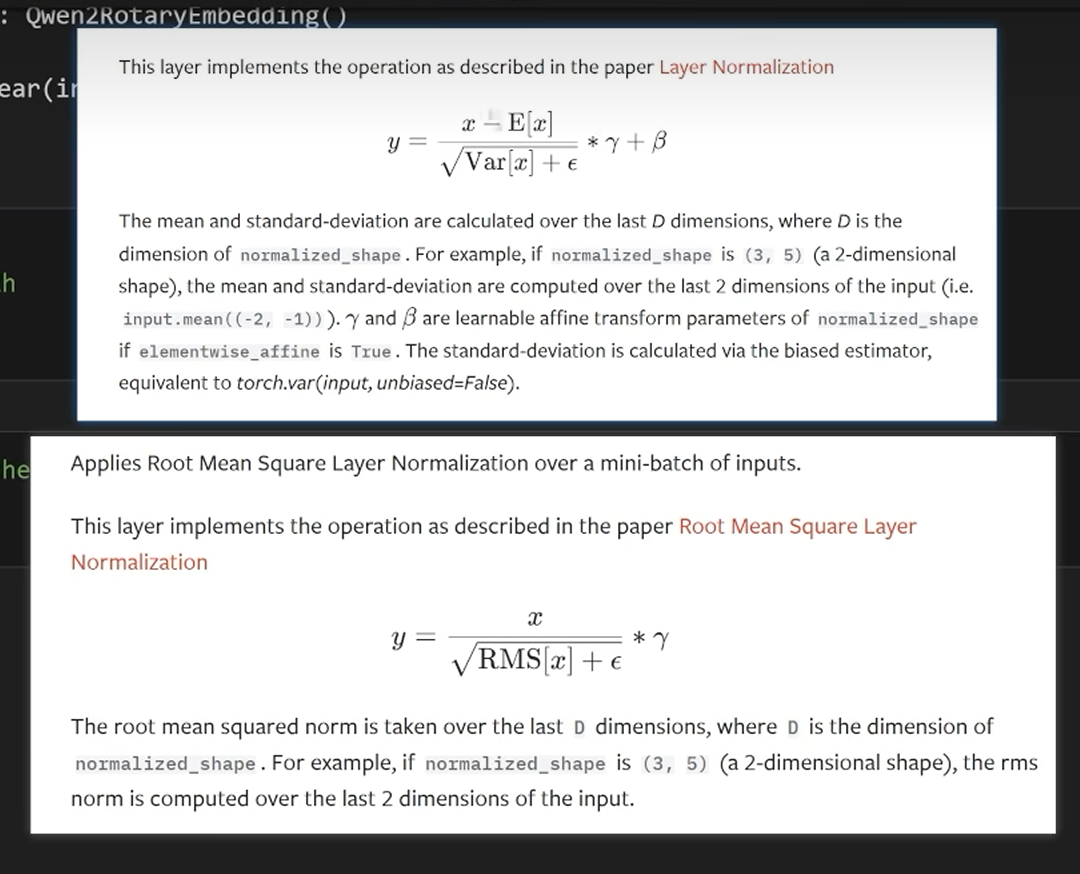

避免了偏置和缩放的依赖： 在传统的LayerNorm中，标准化后的数据会乘以一个可训练的缩放因子（gamma）和加上一个可训练的偏置（beta）。这种做法虽然能够增加模型的灵活性，但也可能导致训练时不稳定的情况。RMSLayerNorm则没有使用缩放因子和偏置，减少了模型的复杂性和训练时的潜在不稳定性。

鲁棒性： RMSLayerNorm采用了Root Mean Square（均方根）而不是平均值来进行归一化，这使得它对不同尺度的特征更加鲁棒。因为RMS是基于方差的，它能更好地反映特征的分布，尤其是在特征的分布非常不均匀或者存在较大方差时。

计算效率： RMSLayerNorm通过计算均方根（RMS）来替代标准化过程中均值和方差的计算，从而减少了计算量。这对于某些任务或网络结构可能会带来轻微的性能提升。

适应性强： RMSLayerNorm在处理不同分布的输入时，表现得更加稳定，尤其是在面对长序列或复杂结构时，能够更好地适应不同类型的数据分布。对于一些训练不稳定或难以收敛的情况，RMSLayerNorm有时能提供更好的效果。

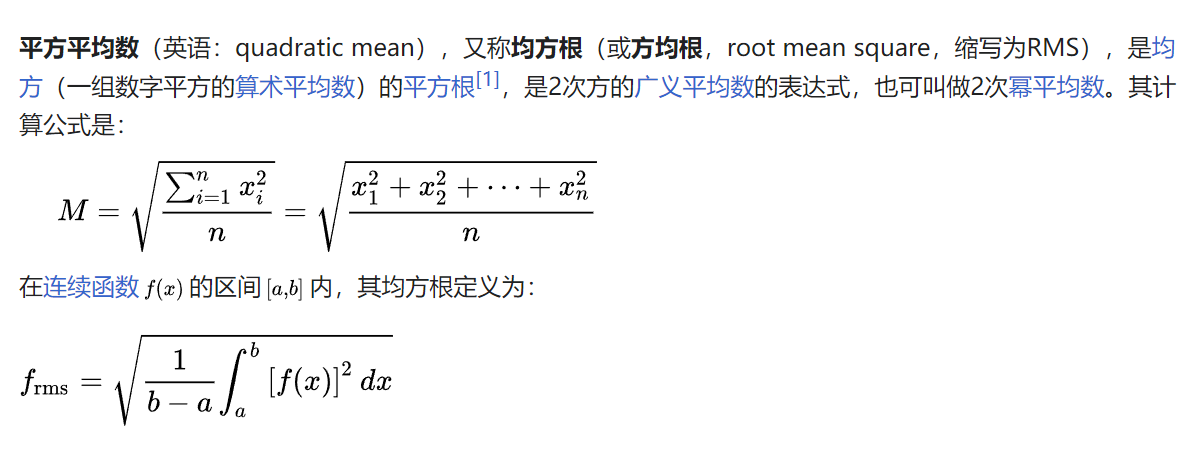